In [77]:
import re
import random
import pandas as pd
import hashlib

In [78]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [79]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OAuth 2.0 RFC6749,356.875527,32.443230,40.019201,11
pfSense,445.200304,37.100025,53.338008,12
CCH Tax Forms Project,478.632734,22.792035,37.293104,21
Accounting,506.857941,29.815173,42.134726,17
Terraform,571.249912,95.208319,126.288846,6
"The Starless Crown, Rollins",833.851464,30.883388,45.253521,27
Active Directory and Azure Files,843.335582,22.792854,37.251103,37
Python + Oauth2.0,1018.387386,44.277712,55.474138,23
FSLogix,1101.693149,91.807762,128.737163,12
Azure Functions + PP365,1131.159303,125.684367,174.918122,9


# Histogram

sum of ages: ~59973.96


<Axes: >

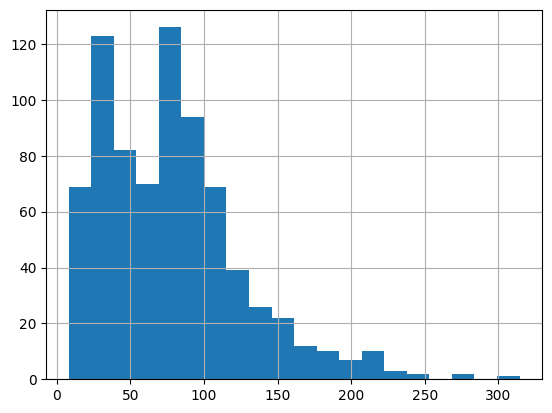

In [80]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~59973.96


<Axes: >

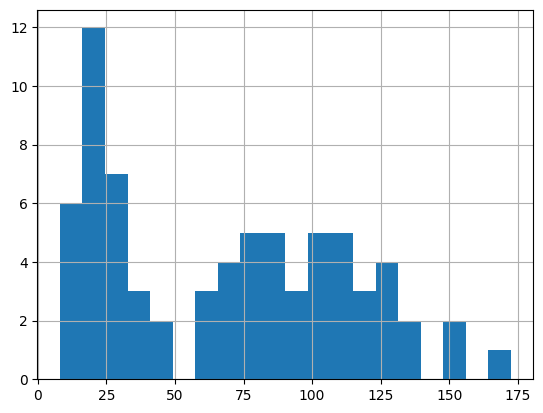

In [92]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [82]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [83]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [84]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [85]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [86]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // 5

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 767
Total card age: 59973.96


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,314.479825,116.608067,-314.479825,5713.795278,0.870068,49,0,0,-314.479825
1,Vocab,"Well of Lost Plots, Fforde\nEminence grise\nno...",ab06a932b5be8ff4bef2de903df7d4c9,219.421772,116.608067,-314.479825,5713.795278,0.870068,49,1,0,-219.421772
2,Vocab,"How to Sell a Haunted House, Hendrix\nTrimalle...",1cbfd950893772c1d42e4c3defaea154,208.964592,116.608067,-314.479825,5713.795278,0.870068,49,2,0,-208.964592
3,Vocab,"Jingo, Pratchett\nCrinoline\nnoun | KRIN-uh-li...",11b8182c8761879e9262b5797bbed0f4,206.236054,116.608067,-314.479825,5713.795278,0.870068,49,3,0,-206.236054
4,Vocab,"Well of Lost Plots, Fforde\nThe Decameron\nnou...",d9044a52b873016ee0bc48f05a511463,186.359492,116.608067,-314.479825,5713.795278,0.870068,49,4,0,-186.359492
5,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,279.898756,120.559913,-279.898756,4581.276678,0.709235,38,0,0,-279.898756
6,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,271.763774,120.559913,-279.898756,4581.276678,0.709235,38,1,0,-271.763774
7,PnP PowerShell,Invoke-WebRequest (Microsoft.PowerShell.Utilit...,6b09af70ff47a16ac9835232449e7bf9,230.485105,120.559913,-279.898756,4581.276678,0.709235,38,2,0,-230.485105
8,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,230.386135,120.559913,-279.898756,4581.276678,0.709235,38,3,0,-230.386135
9,PnP PowerShell,PowerShell Pipeline\nA feature that allows the...,9a180efe01de21f30191a85290e58476,203.450144,120.559913,-279.898756,4581.276678,0.709235,38,4,0,-203.450144


## Card Count

In [87]:
# n=10
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [88]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [89]:
existing_cards.head(10)['age'].sum()

np.float64(2351.4456492069085)

In [90]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,314.479825,116.608067,-314.479825,5713.795278,0.870068,49,0,0,-314.479825
5,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,279.898756,120.559913,-279.898756,4581.276678,0.709235,38,0,0,-279.898756
6,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,271.763774,120.559913,-279.898756,4581.276678,0.709235,38,1,0,-271.763774
10,TSQL,Q: What is the purpose of the GROUP BY clause ...,48a62cc5d988221ac8669ebbd8b27594,243.677944,120.521314,-243.677944,2892.511543,0.234452,24,0,0,-243.677944
20,JavaScript Concepts,When ... appears on the right-hand side of an ...,10bddd23b38f376d792526c3e14f9065,239.771033,82.645808,-239.771033,5206.685907,0.308322,63,0,0,-239.771033
7,PnP PowerShell,Invoke-WebRequest (Microsoft.PowerShell.Utilit...,6b09af70ff47a16ac9835232449e7bf9,230.485105,120.559913,-279.898756,4581.276678,0.709235,38,2,0,-230.485105
8,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,230.386135,120.559913,-279.898756,4581.276678,0.709235,38,3,0,-230.386135
15,Azure VM + Developer,X11 Forwarding\nAn SSH technique that lets GUI...,0541a216239d45b4dd18aaea19bd5712,227.200836,116.178996,-227.200836,3601.548875,0.366595,31,0,0,-227.200836
25,C# Basics,Indexers allow objects to be indexed like arra...,8b8cd7dfc49d7351086701c7627b6136,220.814413,118.677203,-220.814413,2492.221268,0.967263,21,0,0,-220.814413
11,TSQL,Self-Joins for Hierarchies:\n\nUseful for comp...,ead33c6a0051c6b6229a06a68ac14f06,219.606685,120.521314,-243.677944,2892.511543,0.234452,24,1,0,-219.606685


In [91]:
existing_cards['age'].mean()

np.float64(78.1929020507472)